# Переводчик с английского на русский с использование трансформера

In [ ]:
!nvidia-smi

Fri Nov  5 17:05:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Парсинг базы(предобработка)

In [ ]:
import torch
from torch import nn
# import torchtext
from torchtext.data.utils import get_tokenizer # Импортируем токенизатор из pytorch для разделения предложений на слова
from torchtext.vocab import build_vocab_from_iterator # Импортируем итератор для преобразования слов в индексы
from torch.nn.utils.rnn import pad_sequence # Данный иодуль нужен для заполнения тензора еденицами, одинаковая размерность матрицы
import torch.utils.data as data # Имопритируем модуль data, что бы потом из него достать класс Dataloader
import math # Матиматическая функция для вычесления квадратного корня
import re # Регулярные выражения
import pandas as pd
import pickle # Для сохранения в формате pickle
import numpy as np # Numpy
import matplotlib.pyplot as plt # Отрисовка графиков
import matplotlib.ticker as ticker # Деление осей и подписи к ним

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Скачиваем нашу базу
! wget https://www.manythings.org/anki/rus-eng.zip

--2021-11-05 17:08:46--  https://www.manythings.org/anki/rus-eng.zip
Resolving www.manythings.org (www.manythings.org)... 172.67.186.54, 104.21.92.44, 2606:4700:3030::6815:5c2c, ...
Connecting to www.manythings.org (www.manythings.org)|172.67.186.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14385451 (14M) [application/zip]
Saving to: ‘rus-eng.zip’

rus-eng.zip         100%[===================>]  13.72M  19.7MB/s    in 0.7s    

2021-11-05 17:08:47 (19.7 MB/s) - ‘rus-eng.zip’ saved [14385451/14385451]



In [ ]:
# Распаковываем архив с базой
from zipfile import ZipFile
with ZipFile("/content/rus-eng.zip","r") as zip_file:
  zip_file.extractall("temp")

In [ ]:
with open('/content/temp/rus.txt') as f: # Чтение файла
  lines = f.readlines()
text = ''.join(lines) # Конвертируем в тип str

In [ ]:
#####################################################################
##Проходимся циклом по тексту, нам нужны только пары слов русс-англ##
#####################################################################
d = []
for x in text.splitlines():
  # if x.startswith('rus'):
  g = x.split('\t')
  d.append(g)
df = pd.DataFrame(d) # Формируем таблицу из pandas
df # В этой таблице нам нужны колонки 0, 1, остальное удаляем

,0,1,2
0,Go.,Марш!,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1,Go.,Иди.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
2,Go.,Идите.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
3,Hi.,Здравствуйте.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
4,Hi.,Привет!,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
...,...,...,...
431092,Death is something that we're often discourage...,"Смерть - это зачастую то, разговоры или даже м...",CC-BY 2.0 (France) Attribution: tatoeba.org #1...
431093,"At a moment when our economy is growing, our b...","В тот момент, когда наша экономика растёт, наш...",CC-BY 2.0 (France) Attribution: tatoeba.org #3...
431094,Since there are usually multiple websites on a...,"Поскольку сайтов, посвящённых какой-либо теме,...",CC-BY 2.0 (France) Attribution: tatoeba.org #9...
431095,"It's so easy to write good example sentences, ...",Создавать хорошие предложения-примеры так легк...,CC-BY 2.0 (France) Attribution: tatoeba.org #9...


In [ ]:
df = df.iloc[:, :2] # Удаляем все колонки кроме 0 и 1
df[:10].values # Вывод очищенных данных

array([['Go.', 'Марш!'],
       ['Go.', 'Иди.'],
       ['Go.', 'Идите.'],
       ['Hi.', 'Здравствуйте.'],
       ['Hi.', 'Привет!'],
       ['Hi.', 'Хай.'],
       ['Hi.', 'Здрасте.'],
       ['Hi.', 'Здоро́во!'],
       ['Hi.', 'Приветик!'],
       ['Run!', 'Беги!']], dtype=object)

In [ ]:
df.to_csv('/content/temp/base.txt', header=False, index=False, sep='\t', mode='w')

## Работа непосредственно с базой

In [ ]:
# Устанавливаем билиотеку spacy, она нужна нам для правильного чтения текста на двух разных языках
!pip install -U spacy
!python -m spacy download ru_core_news_sm # Чтение русского текста
!python -m spacy download en_core_web_sm # Чтение английского текста
import spacy # Модуль spacy

     |████████████████████████████████| 6.0 MB 7.1 MB/s 
     |████████████████████████████████| 628 kB 59.7 MB/s 
     |████████████████████████████████| 173 kB 71.3 MB/s 
     |████████████████████████████████| 42 kB 1.7 MB/s 
     |████████████████████████████████| 451 kB 60.3 MB/s 
     |████████████████████████████████| 10.1 MB 34.5 MB/s 
  Created wheel for langcodes: filename=langcodes-3.2.1-py3-none-any.whl size=169396 sha256=add6f097d2c09614238f96966fdaa240e55eb033837b76817057bfa8cfd03494
  Stored in directory: /root/.cache/pip/wheels/12/9c/b3/d42c928e622075d3b6056733125190086e44c9230878e6eb2b
Successfully built langcodes
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing 

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Загружаем текст из гугл диска в переменную lines
lines = open('/content/temp/base.txt', encoding='UTF-8').read().strip().split('\n')

In [ ]:
print('Размер базы по количеству строк', len(lines)) # Всего строк в базе - это пары слов и пары предложений английский - русский

Размер базы по количеству строк 431097


In [ ]:
# Функция для обработки текста с помощью регулярных выражений
def text_clean(s):
  s = re.sub(r"[^a-zA-Zа-яёА-ЯЁ?.!,;:'́]+", r' ', s) # Заменяем всё на пробелы, за исключением (a-zA-Zа-яёА-ЯЁ?.!,;:)
  s = re.sub(r'\s+', r' ', s)
  s = s.rstrip().strip() # Получаем строку без случайных лишних пробелов в конце фраз(rstrip удаляет с конца строки)
  return s
text = [[text_clean(s) for s in l.split('\t')]  for l in lines[:125010]] # Берем только 125010 строк из них 10 будет тостовой для проверки сети

In [ ]:
# После обработки базы регулярными выражениями
print('Было {}'.format([lines[0]]))
print('Стало {}'.format(text[0]))

Было ['Go.\tМарш!']
Стало ['Go.', 'Марш!']


In [ ]:
EN_LANGUAGE = 'en'
RU_LANGUAGE = 'ru'

token_transform = {} # Создаем пустой словар для добавления токенов(слов)
vocab_transform = {} # Создаем пустой словарь для добавления индексов слов

token_transform[EN_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm') # Создаем токинезатор для английкого
token_transform[RU_LANGUAGE] = get_tokenizer('spacy', language='ru_core_news_sm') # Создаем токинезатор для русского

# Функция для получения списков токенов (некий генератор)
def yield_tokens(txt, language: str):
  language_index = {EN_LANGUAGE: 0, RU_LANGUAGE: 1}
  for data_sample in txt:
      yield token_transform[language](data_sample[language_index[language]]) # token_transform разделяет нам на слова в текстовом предложении
      # в том числе и оделяет символы такие как знак ?,!,. и.т.д.

# Добавление специальных символов начало и конца предложения, а так же индексов 0 и 1
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Символ <unk> говорит нам о том что если данного слова нет в обучающих текстах
# Символом <pad> мы заполняем пустое место для одинаковой размерности выборки
# Символы <bos>, <eos> начало и конец предложения
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

# С помощью цикла разделяем английский и русский текст
for ln in [EN_LANGUAGE, RU_LANGUAGE]:
    # Итератор build_vocab_from_iterator превращает слова в цифры (индексы)
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(text, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

# По умолчанию устанавливаем нулевой индекс для двух языков
for ln in [EN_LANGUAGE, RU_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)

In [ ]:
print('Токены слов русского', token_transform['ru']('Как твои дела?'), end='\t')
print('Индексы слов русского', vocab_transform['ru'](token_transform['ru']('Как твои дела?')), end='\n')
print('Токены слов английского', token_transform['en']('How are you?'), end='\t')
print('Индексы слов английского', vocab_transform['en'](token_transform['en']('How are you?')), end='\n')

Токены слов русского ['Как', 'твои', 'дела', '?']	Индексы слов русского [55, 552, 679, 6]
Токены слов английского ['How', 'are', 'you', '?']	Индексы слов английского [59, 38, 8, 7]


In [ ]:
# Вспомогательная функция для объединения последовательных операций
def sequential_transforms(*transforms):
  def func(txt_input):
    for transform in transforms:
      txt_input = transform(txt_input)
    return txt_input
  return func

# Функция для добавления BOS / EOS и создания тензора для индексов входной последовательности
def tensor_transform(token_ids):
  return torch.cat((torch.tensor([BOS_IDX]), # Преобразуем в тензор индекс тега ночала предложения
                    torch.tensor(token_ids), # Преобразуем в тензоры сами индексы слов
                    torch.tensor([EOS_IDX]))) # Преобразуем в тензор индекс тега конца предложения

text_transform = {} # Создаем пустой словарь для добавления всех тензоров с учетом индексов ночала и конца предложения
for ln in [EN_LANGUAGE, RU_LANGUAGE]:
  text_transform[ln] = sequential_transforms(token_transform[ln], # Токинизация
                                             vocab_transform[ln], # Превращаем токены(слова) в индексы
                                             tensor_transform) # Добавляем теги BOS/EOS и пробразование в тензоры

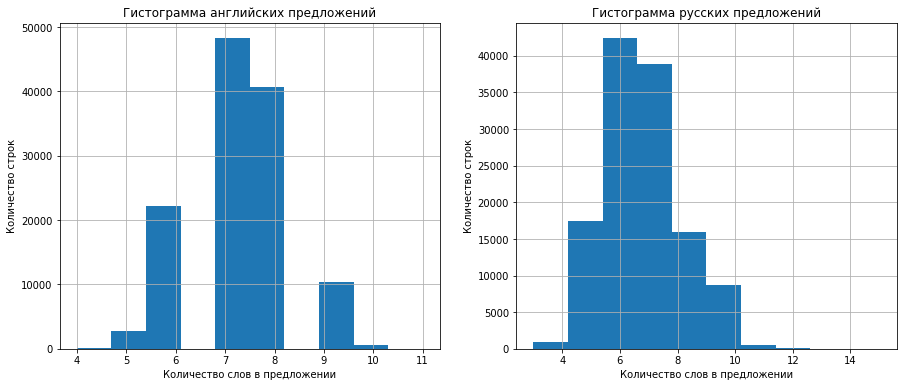

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=False)
axs[0].hist([len(text_transform['en'](text[i][0])) for i in range(len(text))])
axs[0].set_xlabel('Количество слов в предложении')
axs[0].set_ylabel('Количество строк')
axs[0].set_title('Гистограмма английских предложений')
axs[0].grid(True)
axs[1].hist([len(text_transform['ru'](text[i][1])) for i in range(len(text))])
axs[1].set_xlabel('Количество слов в предложении')
axs[1].set_ylabel('Количество строк')
axs[1].set_title('Гистограмма русских предложений')
axs[1].grid(True)
plt.show()

In [ ]:
# Здесь представлен пример с добавлением спициальных символов, таких как <bos> и <eos>
print(vocab_transform['ru'].lookup_tokens(text_transform['ru']('Как твои дела?').tolist()), end='\t')
print(text_transform['ru']('Как твои дела?').tolist(), end='\n')
print(vocab_transform['en'].lookup_tokens(text_transform['en']('How are you?').tolist()), end='\t')
print(text_transform['en']('How are you?').tolist(), end='\n')

['<bos>', 'Как', 'твои', 'дела', '?', '<eos>']	[2, 55, 525, 678, 6, 3]
['<bos>', 'How', 'are', 'you', '?', '<eos>']	[2, 59, 39, 8, 7, 3]


In [ ]:
# Функиция для сопоставления индексов(тензоров) к одному языку и к другому,
# а так же для добивания еденицами, что бы был одинаковой размерностси массив
def collate_fn(batch):
  en_batch, ru_batch = [], []
  for en_sample, ru_sample in batch:
    en_batch.append(text_transform[EN_LANGUAGE](en_sample)) # Сопаставление тензоров к английскому языку
    ru_batch.append(text_transform[RU_LANGUAGE](ru_sample)) # Сопаставление тензоров к русскому языку

  en_batch = pad_sequence(en_batch, padding_value=PAD_IDX) # добивание еденицами в английском
  ru_batch = pad_sequence(ru_batch, padding_value=PAD_IDX) # добивание еденицами в русском
  return en_batch.transpose(0,1), ru_batch.transpose(0,1)

In [ ]:
en, ru = collate_fn(text) # Разбитие на два языка
print('Размерность массива английских слов', en.shape)
print('Размерность массива русских слов', ru.shape)

Размерность массива английских слов torch.Size([125010, 11])
Размерность массива русских слов torch.Size([125010, 15])


In [ ]:
print('Вид первой строки английского языка', ' ', en[0])
print('Вид первой строки русского языка', ' ', ru[0])

Вид первой строки английского языка   tensor([  2, 177,   4,   3,   1,   1,   1,   1,   1,   1,   1])
Вид первой строки русского языка   tensor([   2, 7177,   32,    3,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1])


## Создаем датасет на чем мы будем обучать нашу сеть

In [ ]:
class CustomDataset(data.Dataset):
    def __init__(self, listID, labels, transforms = None):
        self.listID = listID # Список английских слов
        self.labels = labels # Список русских слов
        self.transforms = transforms # если нужны какие-то преобразования трансформации


    def __getitem__(self, index):
        ID = self.listID[index] # итерируем по каждому элементу в списке

        # Если transforms заполнено, то:
        if self.transforms:
          ID = self.transforms(ID) # то, что лежит в transforms применяем этому ID
        trainX = ID # английские слова уходят в trainX для этой итерации
        trainY = self.labels[index] # русские слова уходят в trainY

        # Возвращаем пару англ-русс
        return trainX, trainY

    def __len__(self):
        # Здесь общий размер вашего датасета
        return len(self.listID)

In [ ]:
customData = CustomDataset(en, ru) # Получаем датасет английский и русский
train_size = int(len(customData) - 10) # Тренировочный датасет 125000 строк
test_size = len(customData) - train_size # Тестовый датасет на 10 строк
train_dataset, test_dataset = torch.utils.data.random_split(customData, [train_size, test_size]) # Получение выборок 125000 / 10 строк
train_loader = data.DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=4) # Тренировочная выборка 125000 строк
valid_loader = data.DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=4) # Проверочная выборка точно такая же как и тренировачная на 125000 строк

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Создаем нашу сеть Transformer

###Энкодер

In [ ]:
# Создаем входной Embedding, это так называемы вход в нейросеть куда мы будем подавать наши батчи
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tensor):
        return self.embedding(tensor.long()) * math.sqrt(self.emb_size)

In [ ]:
# Данный класс является частью трансформера, и говорит о том какое слово по счету находится в предложении
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding_tensor):
        return self.dropout(token_embedding_tensor + self.pos_embedding[:token_embedding_tensor.size(0), :])

In [ ]:
class MultiHeadAttentionLayer(nn.Module):
  def __init__(self, hid_dim, n_heads, dropout, device):
    super().__init__()

    assert hid_dim % n_heads == 0

    self.hid_dim = hid_dim
    self.n_heads = n_heads
    self.head_dim = hid_dim // n_heads

    self.q = nn.Linear(hid_dim, hid_dim, bias=True)
    self.k = nn.Linear(hid_dim, hid_dim, bias=True)
    self.v = nn.Linear(hid_dim, hid_dim, bias=True)

    self.o = nn.Linear(hid_dim, hid_dim, bias=True)

    self.dropout = nn.Dropout(dropout)

    self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

  def forward(self, query, key, value, mask = None):
    batch_size = query.shape[0]

    #query = [batch size, query len, hid dim]
    #key = [batch size, key len, hid dim]
    #value = [batch size, value len, hid dim]

    Q = self.q(query)
    K = self.k(key)
    V = self.v(value)

    #Q = [batch size, query len, hid dim]
    #K = [batch size, key len, hid dim]
    #V = [batch size, value len, hid dim]

    Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
    K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
    V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

    #Q = [batch size, n heads, query len, head dim]
    #K = [batch size, n heads, key len, head dim]
    #V = [batch size, n heads, value len, head dim]

    matmul_scale = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

    #matmul_scale = [batch size, n heads, query len, key len]

    # делаем маскирование Mask (opt.)
    if mask is not None:
      matmul_scale = matmul_scale.masked_fill(mask == 0, -1e9)

    # [batch size, 1, trg len, trg len]

    attention = torch.softmax(matmul_scale, dim = -1)

    # [batch size, n heads, query len, key len]

    matmul_ = torch.matmul(self.dropout(attention), V)

    # [batch size, n heads, query len, head dim]

    matmul_ = matmul_.permute(0, 2, 1, 3).contiguous()

    # [batch size, query len, n heads, head dim]

    matmul_ = matmul_.view(batch_size, -1, self.hid_dim)

    # [batch size, query len, hid dim]

    matmul_ = self.o(matmul_)

    # [batch size, query len, hid dim]

    return matmul_, attention

In [ ]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()

        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        #x = [batch size, seq len, hid dim]

        x = self.dropout(torch.relu(self.fc_1(x)))

        #x = [batch size, seq len, pf dim]

        x = self.fc_2(x)

        #x = [batch size, seq len, hid dim]

        return x

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self,
                 hid_dim,
                 n_heads,
                 pf_dim,
                 dropout,
                 device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim,
                                                                     pf_dim,
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):

        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len]

        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)

        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))

        #src = [batch size, src len, hid dim]

        #positionwise feedforward
        _src = self.positionwise_feedforward(src)

        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))

        #src = [batch size, src len, hid dim]

        return src

In [ ]:
class Encoder(nn.Module):
    def __init__(self,
                 input_dim,
                 hid_dim,
                 n_layers,
                 n_heads,
                 pf_dim,
                 dropout,
                 device,
                 max_length = 5000):
        super().__init__()

        self.device = device

        self.tok_embedding = TokenEmbedding(input_dim, hid_dim)
        self.pos_embedding = PositionalEncoding(hid_dim, dropout, max_length)

        self.layers = nn.ModuleList([EncoderLayer(hid_dim,
                                                  n_heads,
                                                  pf_dim,
                                                  dropout,
                                                  device)
                                     for _ in range(n_layers)])

        self.dropout = nn.Dropout(dropout)

        # self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, src, src_mask):

        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]

        src = self.tok_embedding(src)
        src = self.pos_embedding(src)

        # batch_size = src.shape[0]
        # src_len = src.shape[1]

        # pos = torch.arange(0, src_len).view(1,-1).repeat(batch_size, 1).to(self.device)
        # pos = self.tok_embedding(pos)

        #pos = [batch size, src len]

        # src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        src = self.dropout(src)

        #src = [batch size, src len, hid dim]

        for layer in self.layers:
            src = layer(src, src_mask)

        #src = [batch size, src len, hid dim]

        return src

### Декодер

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self,
                 hid_dim,
                 n_heads,
                 pf_dim,
                 dropout,
                 device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim,
                                                                     pf_dim,
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)

        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))

        #trg = [batch size, trg len, hid dim]

        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)

        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))

        #trg = [batch size, trg len, hid dim]

        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)

        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))

        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]

        return trg, attention

In [ ]:
class Decoder(nn.Module):
    def __init__(self,
                 output_dim,
                 hid_dim,
                 n_layers,
                 n_heads,
                 pf_dim,
                 dropout,
                 device,
                 max_length = 5000):
        super().__init__()

        self.device = device

        self.tok_embedding = TokenEmbedding(output_dim, hid_dim)
        self.pos_embedding = PositionalEncoding(hid_dim, dropout, max_length)
        # self.softmax = nn.Softmax(dim=-1)

        self.layers = nn.ModuleList([DecoderLayer(hid_dim,
                                                  n_heads,
                                                  pf_dim,
                                                  dropout,
                                                  device)
                                     for _ in range(n_layers)])

        self.out_linear = nn.Linear(hid_dim, output_dim)

        self.dropout = nn.Dropout(dropout)

        # self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        trg = self.tok_embedding(trg)
        trg = self.pos_embedding(trg)

        # batch_size = trg.shape[0]
        # trg_len = trg.shape[1]

        # pos = torch.arange(0, trg_len).view(1,-1).repeat(batch_size, 1).to(self.device)
        # pos = self.tok_embedding(pos)

        #pos = [batch size, trg len]

        # trg = self.tok_embedding(trg) * self.scale + self.pos_embedding(pos)
        # trg = self.dropout(trg)

        #trg = [batch size, trg len, hid dim]

        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]

        output = self.out_linear(trg)
        # output = self.softmax(output)

        #output = [batch size, trg len, output dim]

        return output, attention

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([512, 1, 15, 15])


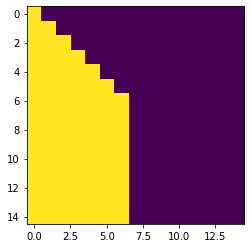

In [ ]:
# Демонстрация того как выклядит маска(маскирование) русских слов для декодера
iteration_ru = next(iter(valid_loader))[1].to(device)
trg_pad_mask = (iteration_ru != 1).unsqueeze(1).unsqueeze(2).to(device)
trg_sub_mask = torch.tril(torch.ones((iteration_ru.shape[1], iteration_ru.shape[1]))).bool().to(device)
trg_mask = trg_pad_mask & trg_sub_mask
print(trg_mask.shape)
plt.imshow(trg_mask[0][0].cpu().numpy())
plt.show()

### Собираем модель

In [ ]:
# Собираем модель
class make_model(nn.Module):
    def __init__(self,
                 encoder,
                 decoder,
                 device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device
     # Маска для энкодера
    def make_src_mask(self, src):

        #src = [batch size, src len]

        src_mask = (src != 1).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
     # Маска для декодера
    def make_trg_mask(self, trg):

        #trg = [batch size, trg len]

        trg_pad_mask = (trg != 1).unsqueeze(1).unsqueeze(2)

        #trg_pad_mask = [batch size, 1, 1, trg len]

        trg_len = trg.shape[1]

        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()

        #trg_sub_mask = [trg len, trg len]

        # [batch_size, 1, trg_len, trg_len]

        trg_mask = trg_pad_mask & trg_sub_mask

        #trg_mask = [batch size, 1, trg len, trg len]

        return trg_mask

    def forward(self, src, trg):

        #src = [batch size, src len]
        #trg = [batch size, trg len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]

        enc_src = self.encoder(src, src_mask) # На вход экодера подаем токенезированный английский

        #enc_src = [batch size, src len, hid dim]

        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask) # На вход декодера подаем выход из экодера и токенезированный русский

        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]

        return output, attention # Выход из функции, то что предсказала сеть и механизми внимания

In [ ]:
# Гипер параметры для модели
INPUT_DIM = len(vocab_transform['en']) # Количество уникальных токенов в английском
OUTPUT_DIM = len(vocab_transform['ru']) # Количество уникальных токенов в русском
HID_DIM = 128 # Размер скрытого пространства
ENC_LAYERS = 3 # Количество словем в экодере
DEC_LAYERS = 3 # Количество слоев в декодере
ENC_HEADS = 8 # Количество голов в энкодере
DEC_HEADS = 8 # Количество голов в декодере
ENC_PF_DIM = 512 # Размер линейного слоя для энкодера
DEC_PF_DIM = 512 # Размер линейного слоя для декодера
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM,
              HID_DIM,
              ENC_LAYERS,
              ENC_HEADS,
              ENC_PF_DIM,
              ENC_DROPOUT,
              device)

dec = Decoder(OUTPUT_DIM,
              HID_DIM,
              DEC_LAYERS,
              DEC_HEADS,
              DEC_PF_DIM,
              DEC_DROPOUT,
              device)
model = make_model(enc, dec, device).to(device)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Модель имеет {count_parameters(model):,} обучаемых параметров')

Модель имеет 9,181,140 обучаемых параметров


**Функция инициализации весов в слоях по методу Xavier**

**Данный метод устанавливает веса слоев на значения,
выбранные из случайного равномерного распределения, которое ограничено между**

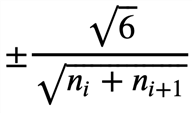

In [ ]:
def initialize_weights(m):
  if hasattr(m, 'weight') and m.weight.dim() > 1:
    nn.init.xavier_uniform_(m.weight.data)
model.apply(initialize_weights);

## Процесс обучения

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = 5e-4) # Оптимизатор Адам
criterion = nn.CrossEntropyLoss(ignore_index = 1) # Кросентропия, функция ошибки(Loss)

In [ ]:
# Функция для процесса обучения
def model_train(model, iterator, optimizer):
  model.train()
  losses = 0

  for src, tgt in iterator:
    src = src.to(device) #src = [batch size, src len]
    tgt = tgt.to(device) #tgt = [batch size, tgt len]
    optimizer.zero_grad()
    output, _ = model(src, tgt[:,:-1]) #output = [batch size, tgt len - 1, output dim]

    loss = criterion(output.reshape(-1, output.shape[-1]), # output = [batch size * tgt len - 1, output dim]
                                    tgt[:,1:].reshape(-1)) # trg = [batch size * tgt len - 1]
    loss.backward()
    optimizer.step()
    losses += loss.item() # Прибавляем значение loss на этапе обучения
  return losses / len(iterator) # Возвращаем ошибку обучения (величена loss)
# Функция для процесса предсказания
def model_evaluate(model, iterator):
  model.eval()
  src_ = text_transform['en']("I worked on it for a long").view(1, -1).to(device) # Я работал над этим долго
  src_mask = model.make_src_mask(src_).to(device) # Создаем маску для входа в энкодер
  enc_src = model.encoder(src_, src_mask).detach() # Получаем выход из энкодера
  trg_indexes = [2] # Стартовый индекс (<bos>) с которого начинается слово или предложение
  losses = 0

  for src, tgt in iterator:
    src = src.to(device) #src = [batch size, src len]
    tgt = tgt.to(device) #tgt = [batch size, tgt len]

    output, _ = model(src, tgt[:,:-1]) #output = [batch size, tgt len - 1, output dim]

    loss = criterion(output.detach().reshape(-1, output.detach().shape[-1]), # output = [batch size * tgt len - 1, output dim]
                                    tgt[:,1:].reshape(-1)) # trg = [batch size * tgt len - 1]
    losses += loss.item() # Прибавляем значение loss на этапе проверки
    # Ниже (после этого комментария) код представлен для того что бы при обучении сеть нам показывала перевод с англ - русс после каждой эпохи
  for i in range(src_.shape[-1]):
    trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device) # Создаем двухмерный тензор из страртового индекса 2-ка
    trg_mask = model.make_trg_mask(trg_tensor) # Создаем маску для входа в декодер, так же из стартового индкса 2-ка
    output_, _ = model.decoder(trg_tensor, enc_src, trg_mask, src_mask) # Получаем то, что выдал нам декодер
    pred_token = output_.detach().argmax(2)[:,-1].item() # Вычесляем предсказиние сети с помощью argmax
    trg_indexes.append(pred_token) # Добавляем то, что нам предскзала сеть к стартовому индексу
    if pred_token == vocab_transform['ru'].vocab.get_stoi()['<eos>']: # По найденому символу <eos>, останавливаем цикл. Это говорит о том, что предложение закончилось
      break
    trg_tokens = [vocab_transform['ru'].vocab.itos_[i] for i in trg_indexes] # Выстраиваем предложение на русском с символами начала и конца предложения
  return losses / len(iterator), trg_tokens[1:-1] # Вовращаем ошибку проверки (величена loss)

In [ ]:
# Запускаем сам процесс обучения, в ходе которого мы будем видеть как обучается нейросеть
# переводя предложение I worked on it for a long - Я работал над этим долго
from timeit import default_timer as timer
num_epochs = 40 # Задаем количество эпох

train_history = [] # Создаем пустой лист для ошибки обучения
valid_history = [] # Создаем пустой лист для ошибки проверки

for epoch in range(1, num_epochs+1): # Проходимся циклом по каждой эпохе
  start_time = timer()
  train_loss = model_train(model, train_loader, optimizer) # Отдаем модели обучающую выборку равную по количеству батчей, получаем ошибку
  end_time = timer()
  val_loss, prediction = model_evaluate(model, valid_loader) # Получаем от модели то что она нам выдала на данной эпохе, получаем ошибку
  train_history.append(train_loss) # Добавляем ошибку при обучении в список
  valid_history.append(val_loss) # Добавляем ошибку при предсказании в список
  print('Эпоха: [%d/%d], Ошибка обучения: %.3f, Ошибка проверки: %.3f, Время эпохи %.3f'
        % (epoch, num_epochs, train_loss, val_loss, (end_time - start_time)))
  print(prediction)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Эпоха: [1/40], Ошибка обучения: 5.753, Ошибка проверки: 4.205, Время эпохи 23.296
['Я', 'не', 'не', 'не', 'не']
Эпоха: [2/40], Ошибка обучения: 3.850, Ошибка проверки: 3.364, Время эпохи 23.160
['Я', 'хочу', ',', 'что', 'я']
Эпоха: [3/40], Ошибка обучения: 3.179, Ошибка проверки: 2.760, Время эпохи 23.198
['Я', 'в', 'этом', 'в', 'этом', 'в', 'порядке']
Эпоха: [4/40], Ошибка обучения: 2.707, Ошибка проверки: 2.335, Время эпохи 23.131
['Я', 'в', 'этом', 'был', 'ребёнок']
Эпоха: [5/40], Ошибка обучения: 2.344, Ошибка проверки: 1.968, Время эпохи 23.188
['Я', 'в', 'этом', 'был', 'в', 'этом', 'поздно']
Эпоха: [6/40], Ошибка обучения: 2.042, Ошибка проверки: 1.675, Время эпохи 23.235
['Я', 'была', 'в', 'этом', 'день']
Эпоха: [7/40], Ошибка обучения: 1.785, Ошибка проверки: 1.430, Время эпохи 23.232
['Я', 'живу', 'в', 'этом', 'уж', 'один']
Эпоха: [8/40], Ошибка обучения: 1.574, Ошибка проверки: 1.232, Время эпохи 23.275
['Я', 'раньше', 'был', 'в', 'этом', 'уж', 'раз']
Эпоха: [9/40], Ошибка об

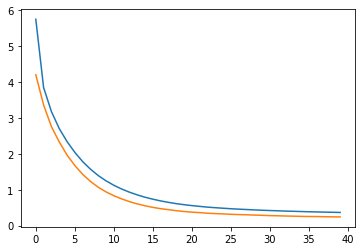

In [ ]:
plt.plot(train_history)
plt.plot(valid_history)
plt.show()

In [ ]:
# Еще раз запускаем процесс обучения с количеством 5 эпох, но только уже с ленинг рейт 5e-5
optimizer = torch.optim.Adam(model.parameters(), lr = 5e-5) # Оптимизатор Адам
num_epochs = 5 # Задаем количество эпох

train_history = [] # Создаем пустой лист для ошибки обучения
valid_history = [] # Создаем пустой лист для ошибки проверки

for epoch in range(1, num_epochs+1): # Проходимся циклом по каждой эпохе
  start_time = timer()
  train_loss = model_train(model, train_loader, optimizer) # Отдаем модели обучающую выборку равную по количеству батчей, получаем ошибку
  end_time = timer()
  val_loss, prediction = model_evaluate(model, valid_loader) # Получаем от модели то что она нам выдала на данной эпохе, получаем ошибку
  train_history.append(train_loss) # Добавляем ошибку при обучении в список
  valid_history.append(val_loss) # Добавляем ошибку при предсказании в список
  print('Эпоха: [%d/%d], Ошибка обучения: %.3f, Ошибка проверки: %.3f, Время эпохи %.3f'
        % (epoch, num_epochs, train_loss, val_loss, (end_time - start_time)))
  print(prediction)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Эпоха: [1/5], Ошибка обучения: 0.321, Ошибка проверки: 0.222, Время эпохи 23.203
['Я', 'работал', 'на', 'неё', 'надолго']
Эпоха: [2/5], Ошибка обучения: 0.309, Ошибка проверки: 0.218, Время эпохи 23.183
['Я', 'работал', 'на', 'это', 'долго']
Эпоха: [3/5], Ошибка обучения: 0.305, Ошибка проверки: 0.215, Время эпохи 23.207
['Я', 'работал', 'на', 'это', 'долго']
Эпоха: [4/5], Ошибка обучения: 0.302, Ошибка проверки: 0.212, Время эпохи 23.180
['Я', 'работал', 'на', 'это', 'долго']
Эпоха: [5/5], Ошибка обучения: 0.300, Ошибка проверки: 0.211, Время эпохи 23.186
['Я', 'работал', 'на', 'это', 'долго']


In [ ]:
torch.save(model, '/content/drive/MyDrive/База/translate_txt/model(30.10.21).pkl')

In [ ]:
model = torch.load('/content/drive/MyDrive/База/translate_txt/model(30.10.21).pkl')

## Предикт (Провека сети на произвольном тексте)

In [ ]:
# Функция для проверки перевода с английского на русский
def translate_sentence(sentence, model, device, max_len):
  model.eval()
  src_mask = model.make_src_mask(sentence) # Создаем маску для экодера
  with torch.no_grad(): # Убираем градиенты
    enc_src = model.encoder(sentence, src_mask).to(device) # Получаем данные на выходе из энкодера без градиента
  trg_indexes = [2] # Стартовый индекс <bos> с которога начинается предложение
  for i in range(max_len): # Проходимся циклом по колличеству слов в предложении
    trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device) # Создаем тензор из 2-ки (стартовый индекс)
    trg_mask = model.make_trg_mask(trg_tensor) # Создаем маску для декодера
    with torch.no_grad(): # Убираем градиенты
      output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask) # Получаем предсказания и тензоры с вниманием
                                                                                  # на выходе из декодера без градиента
    # print(output.argmax(2)[:,-1])
    pred_token = output.argmax(2)[:,-1].item() # Аргмах по предсказанию
    trg_indexes.append(pred_token) # Добавляем в список вместе с индексом 2-ки
    if pred_token == vocab_transform['ru'].vocab.get_stoi()['<eos>']: # По найденому символу <eos>, останавливаем цикл. Это говорит о том, что предложение закончилось
      break
  if sentence[0][1].item() == 0: # Если не встречаем такого слова в базе, то выводим print
    print('Нет такого слова в словаре')
  else:
    trg_tokens = [vocab_transform['ru'].vocab.itos_[i] for i in trg_indexes] # Выстраиваем предложение на русском с символами начала и конца предложения
    return trg_tokens[1:], attention # Получаем переводенное предложение и тензоры внимания

In [ ]:
# Создаем функцию для построение плота с весами внимания
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(5,5)) # Размер полотна
    ax = fig.add_subplot(1, 1, 1)
    _attention = attention.squeeze(0)[0].cpu().numpy() # Убираем нулевую ось у матрицы механизма внимания и переводим в numpy
    ax.matshow(_attention, cmap='bone') # То какого вида будет кореляция на графике

    fontdict = {'fontsize': 14} # Размер текста на графике

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90) # Отображение английского текста по оси X
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict) # Отображение русского текста по оси Y

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1)) # Для отрисовки графика
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [ ]:
# Функция для отображения перевода на русский текст и отображение графика кореляции
def translate(txt):
  src = text_transform['en'](txt).view(1, -1).to(device)
  sr = vocab_transform['en'].lookup_tokens(src.squeeze(0).tolist())
  translation, attention = translate_sentence(src, model, device, src.shape[-1])
  print(f'Перевод = {translation}')
  plot_attention(attention, sr, translation)

Перевод = ['Я', 'потерял', 'ключи', 'от', 'машины', '.', '<eos>']


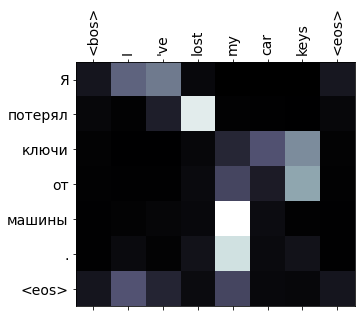

In [ ]:
translate("I've lost my car keys")

Перевод = ['Мой', 'папа', 'пошёл', 'в', 'магазин', '.', '<eos>']


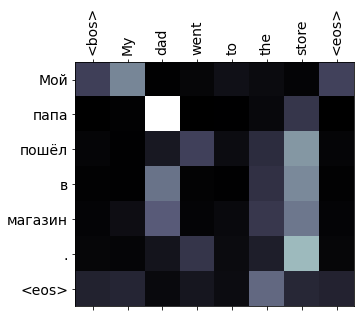

In [ ]:
translate("My dad went to the store")

Перевод = ['Вы', 'в', 'порядке', '.', '<eos>']


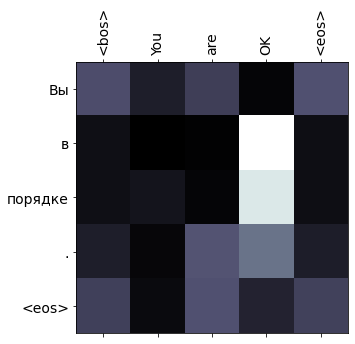

In [ ]:
translate("You are OK")

Перевод = ['С', 'тобой', 'всё', 'в', 'порядке', '?']


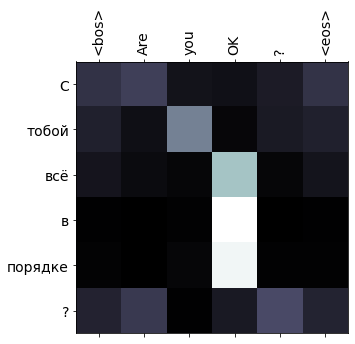

In [ ]:
translate("Are you OK?")

Перевод = ['Мой', 'папа', 'ездит', 'на', 'лошади', '.', '<eos>']


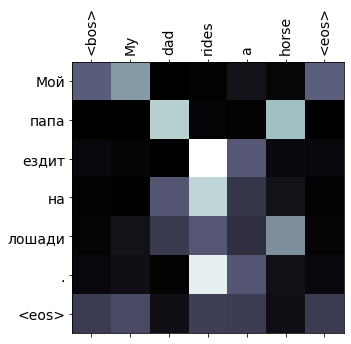

In [ ]:
translate("My dad rides a horse")

## Проверка сети на тестовой выборки

In [ ]:
# Сдесь показано отображение тестового датасета test_dataset который из 10 строк
src_list = [] # Создаем пустой лист для английского
trg_list = [] # Создаем пустой лист для русского
for i, g in test_dataset: # Тестовый датасет
  src_list.append(i) # Создаем лист из 10 тензоров английский язык
  trg_list.append(g) # Создаем лист из 10 тензоров русский язык
en_test = [[i for i in h.tolist() if i>3] for h in src_list] # Получаем лист из индексов из тестового датасета английских слов
ru_test = [[i for i in h.tolist() if i>3] for h in trg_list] # Получаем лист из индексов из тестового датасета русских слов
for g in range(10):
  print('Фраза оригинал на английском', vocab_transform['en'].lookup_tokens(en_test[g]))
  print('Фраза оригинал на русском', vocab_transform['ru'].lookup_tokens(ru_test[g]))

Фраза оригинал на английском ['Look', 'at', 'this', 'photo', '.']
Фраза оригинал на русском ['Посмотри', 'на', 'эту', 'фотографию', '.']
Фраза оригинал на английском ['I', "'m", 'cold', '.']
Фраза оригинал на русском ['Мне', 'холодно', '.']
Фраза оригинал на английском ['Do', 'you', 'have', 'a', 'question', '?']
Фраза оригинал на русском ['У', 'вас', 'какой', 'то', 'вопрос', '?']
Фраза оригинал на английском ['School', 'bores', 'me', '.']
Фраза оригинал на русском ['В', 'школе', 'мне', 'скучно', '.']
Фраза оригинал на английском ['I', 'have', 'done', 'a', 'good', 'job', '.']
Фраза оригинал на русском ['Я', 'сделал', 'хорошую', 'работу', '.']
Фраза оригинал на английском ['The', 'music', 'stopped', '.']
Фраза оригинал на русском ['Музыка', 'смолкла', '.']
Фраза оригинал на английском ['Did', 'you', 'see', 'what', 'I', 'did', '?']
Фраза оригинал на русском ['Ты', 'видела', ',', 'что', 'я', 'сделал', '?']
Фраза оригинал на английском ['That', "'s", 'the', 'key', '.']
Фраза оригинал на рус

In [ ]:
# Функция отображения механизьма внимания по каждой из 8 голов декодера
def display_attention(num, n_heads = 8, n_rows = 4, n_cols = 2):
  print('\x1b[1;30m'+ f'Оригинал перевода = {vocab_transform["ru"].lookup_tokens(ru_test[num])}'+ '\x1b[0m')
  fig = plt.figure(figsize=(25,25)) # Размер полотна фигуры
  sentence = vocab_transform['en'].lookup_tokens(en_test[num]) # Преобразование индексов в слова из тестового датасета
  predict, atent = translate_sentence(src_list[num].view(1, -1).to(device), model, device, src_list[num].shape[0]) # Получение предскажания и механизьма внимания из сети
  print('\x1b[1;30m'+ f'То что перевела нейросеть = {predict}'+ '\x1b[0m')
  for i in range(n_heads):
    ax = fig.add_subplot(n_rows, n_cols, i+1) # Здесь мы определяем во сколько столбцов и строк будет выводиться наши полотна в количестве 8 штук
    _attention = atent.squeeze(0)[i].cpu().detach().numpy() # С механизьма внимания убираем нулевую ось и переводим в numpy
    ax.matshow(_attention, cmap='bone') # То какого вида будет кореляция на графике
    fontdict = {'fontsize': 14} # Размер текста по осям X и Y
    ax.set_xticklabels([''] + ['<bos>'] + sentence + ['<eos>'], fontdict=fontdict, rotation=45) # Отображение текста по оси X, это текст который подовался в нейросеть для перевода
    ax.set_yticklabels([''] + predict, fontdict=fontdict) # Отображение текста по оси Y, это текст который пресказала нейросеть
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
  plt.show()
  print()
  plt.close()

Оригинал перевода = ['Посмотри', 'на', 'эту', 'фотографию', '.']
То что перевела нейросеть = ['Посмотрите', 'на', 'эту', 'фотографию', '.', '<eos>']


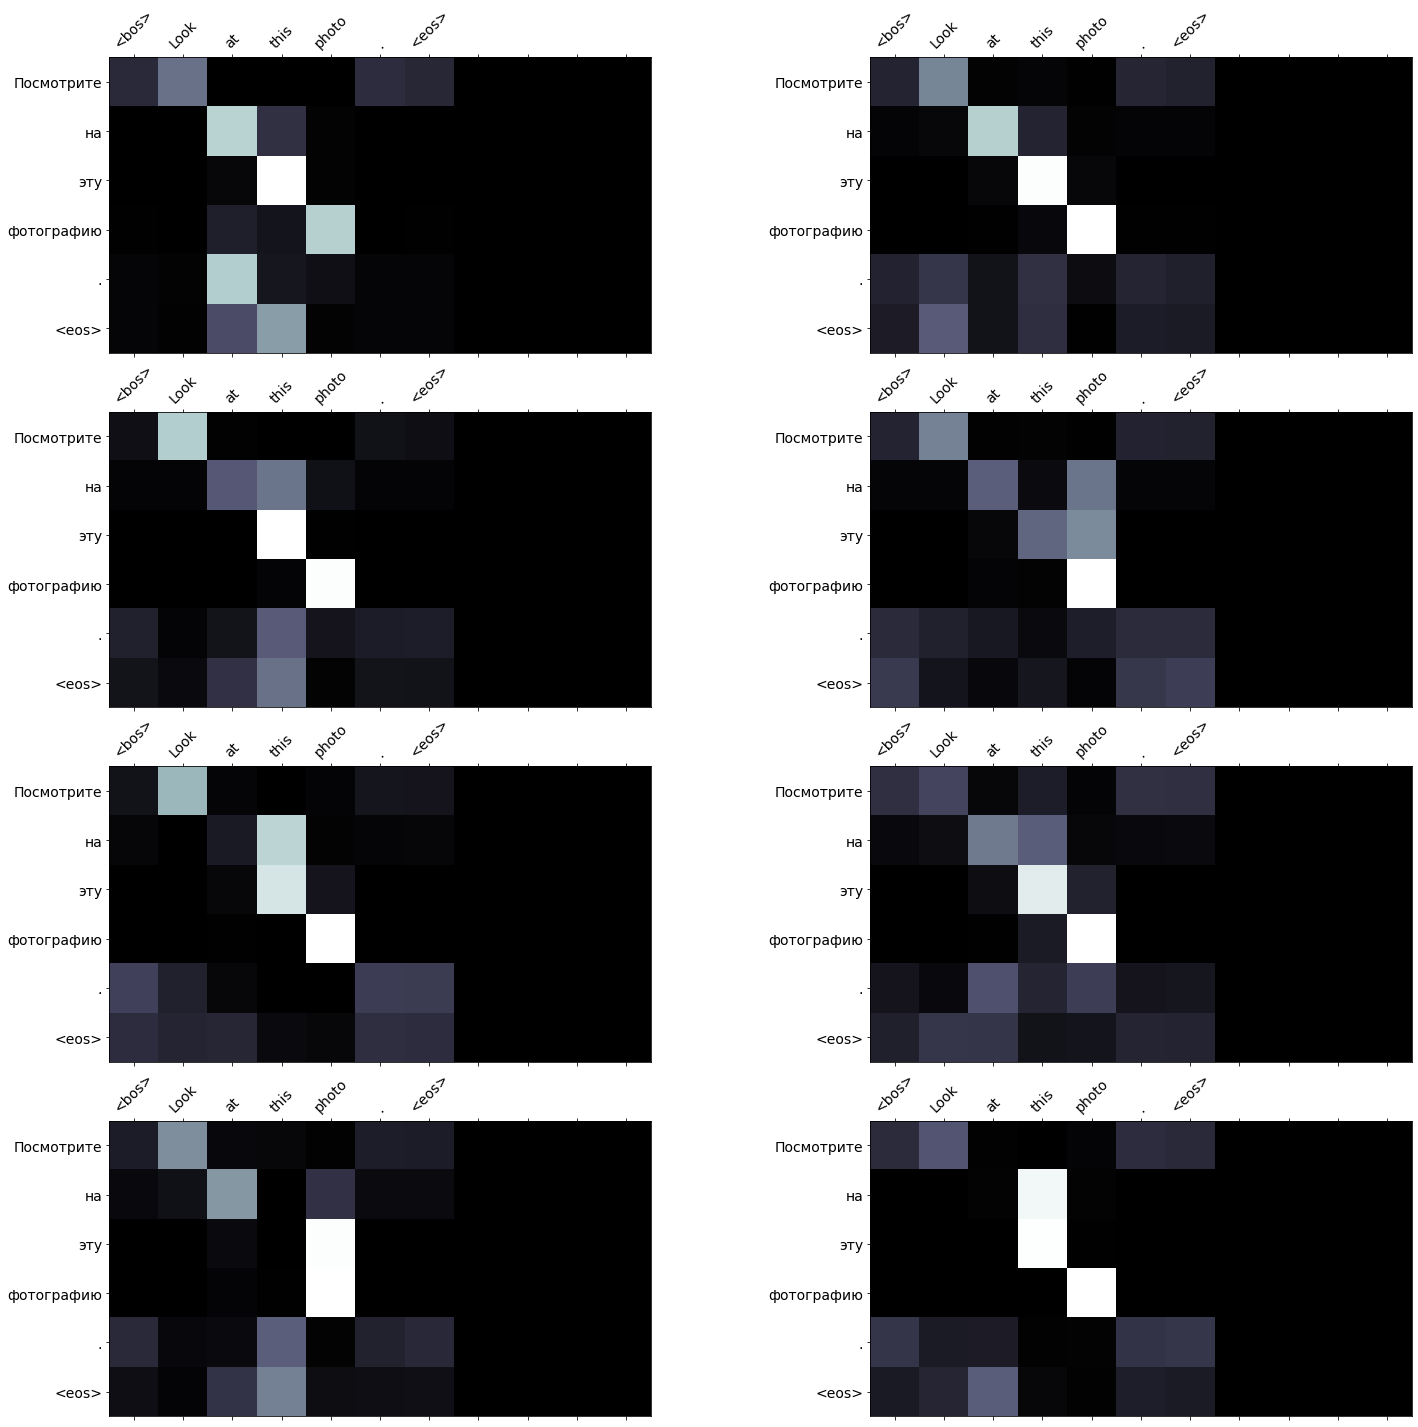


Оригинал перевода = ['Мне', 'холодно', '.']
То что перевела нейросеть = ['Я', 'замёрзла', '.', '<eos>']


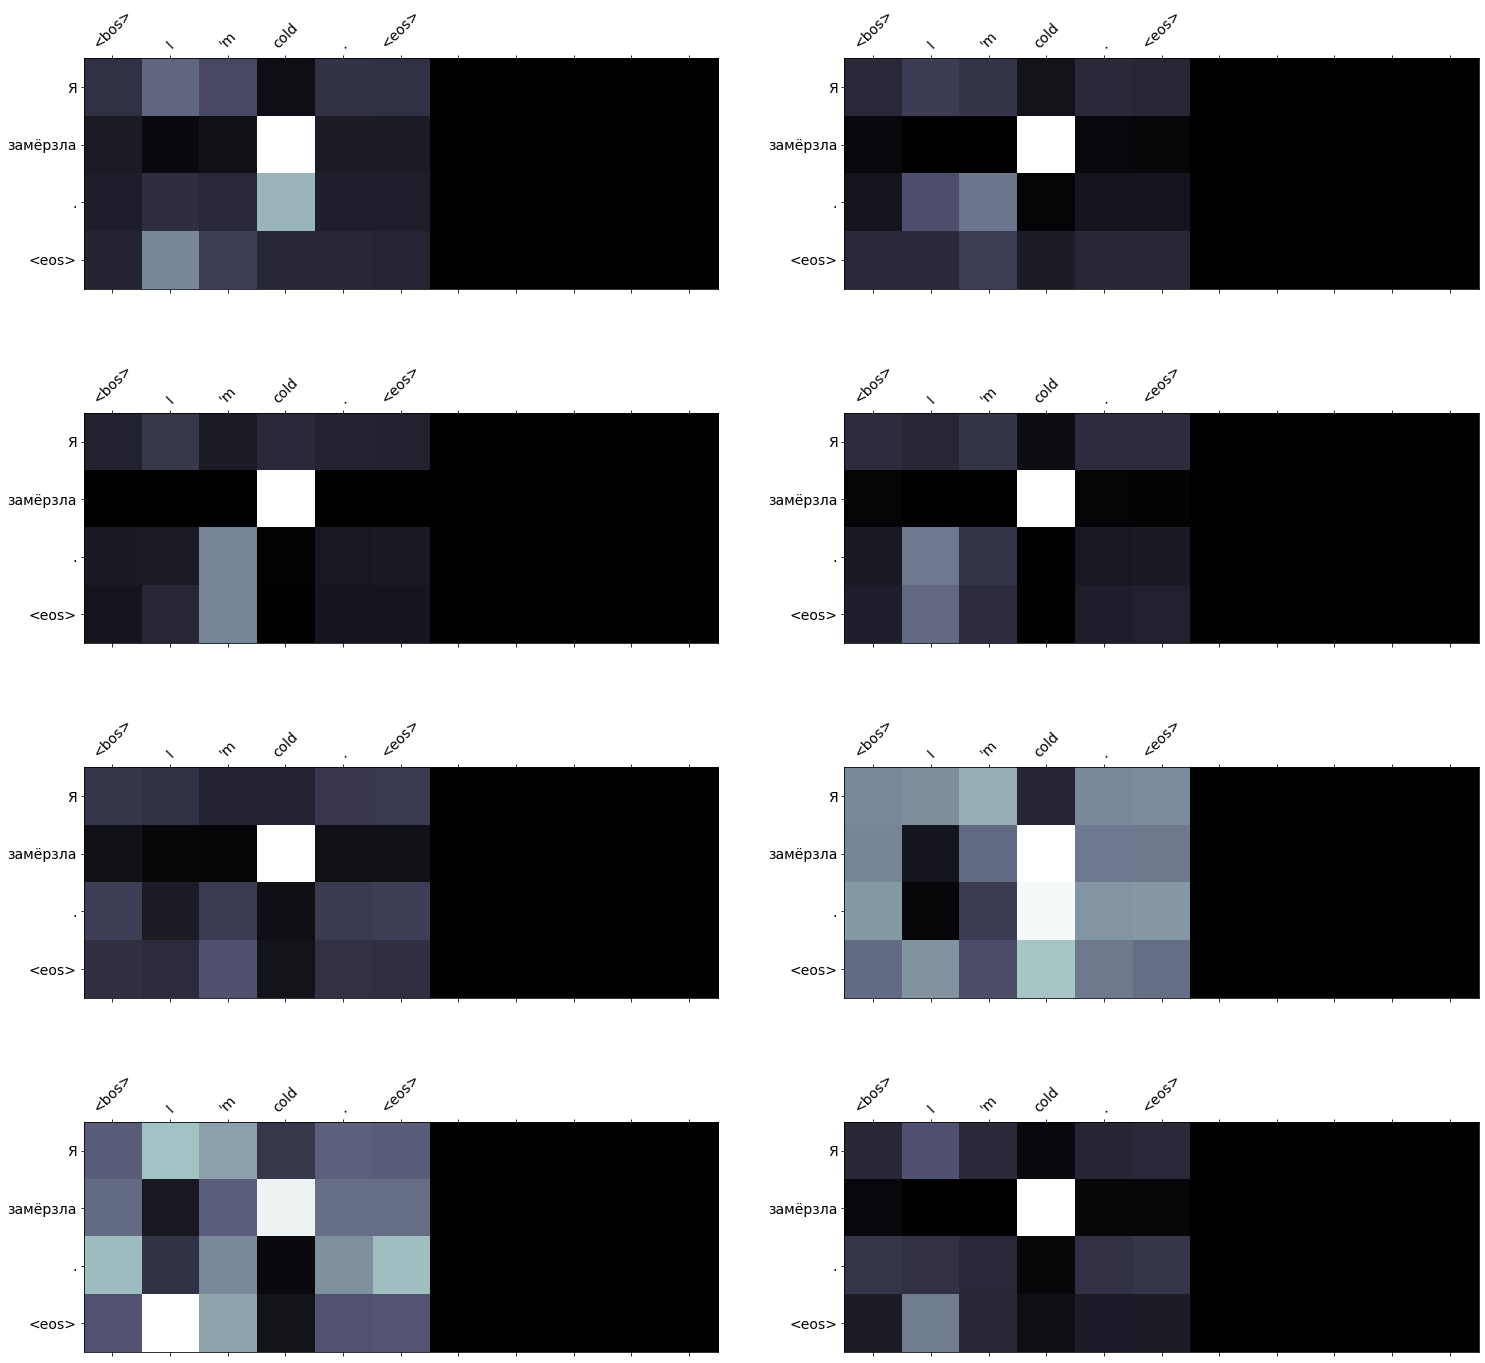


Оригинал перевода = ['У', 'вас', 'какой', 'то', 'вопрос', '?']
То что перевела нейросеть = ['У', 'тебя', 'какой', 'то', 'вопрос', '?', '<eos>']


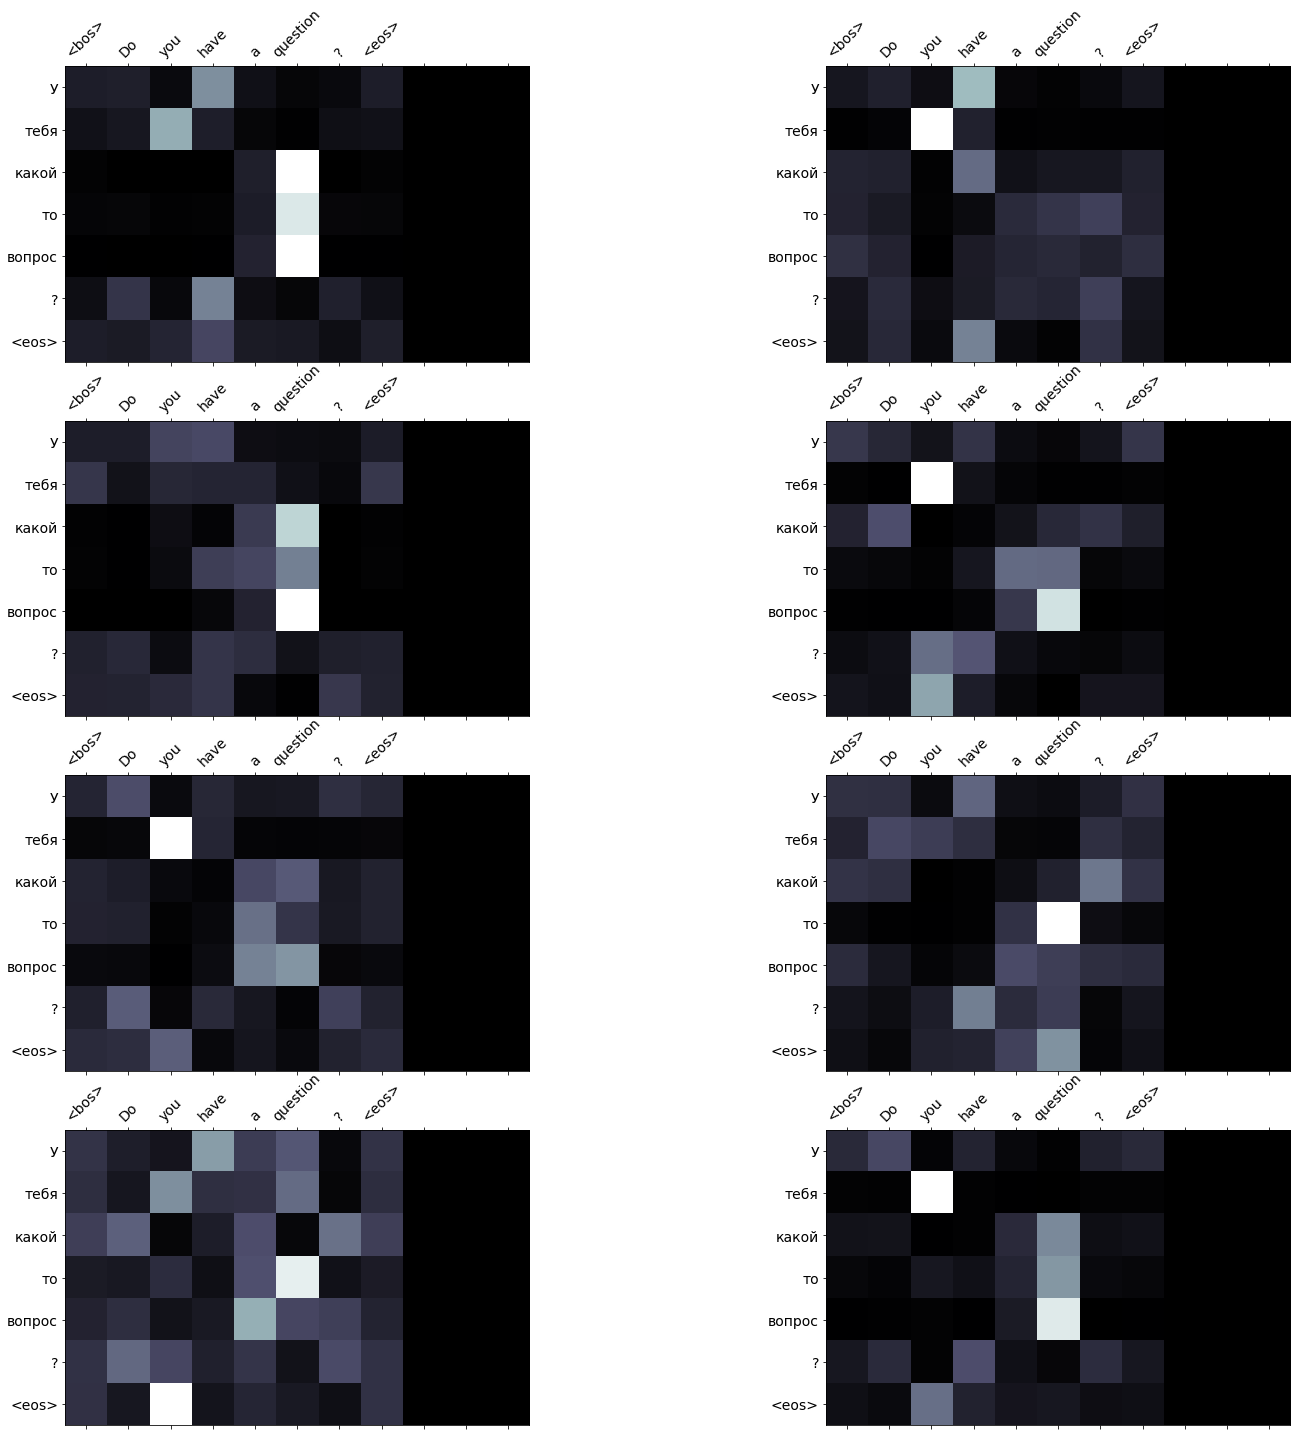


Оригинал перевода = ['В', 'школе', 'мне', 'скучно', '.']
То что перевела нейросеть = ['В', 'школе', 'мне', 'скучно', '.', '<eos>']


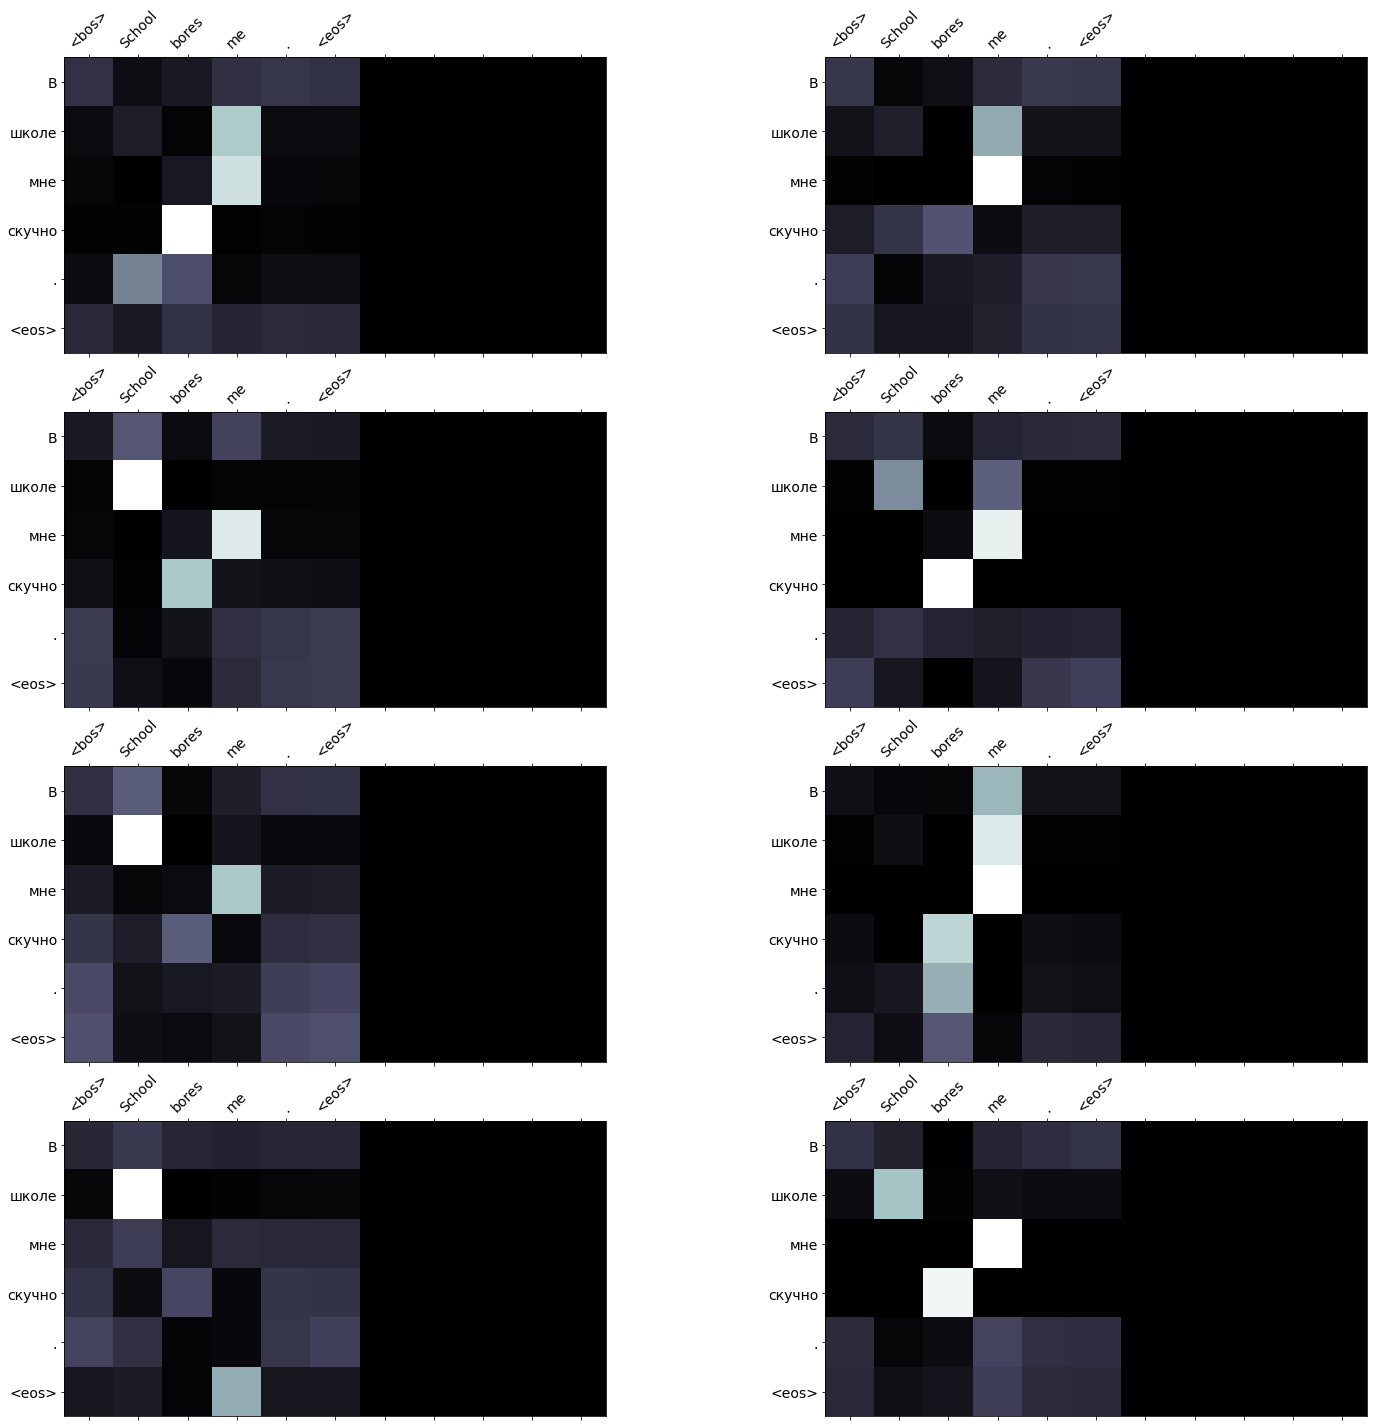


Оригинал перевода = ['Я', 'сделал', 'хорошую', 'работу', '.']
То что перевела нейросеть = ['Я', 'проделала', 'хорошую', 'работу', '.', '<eos>']


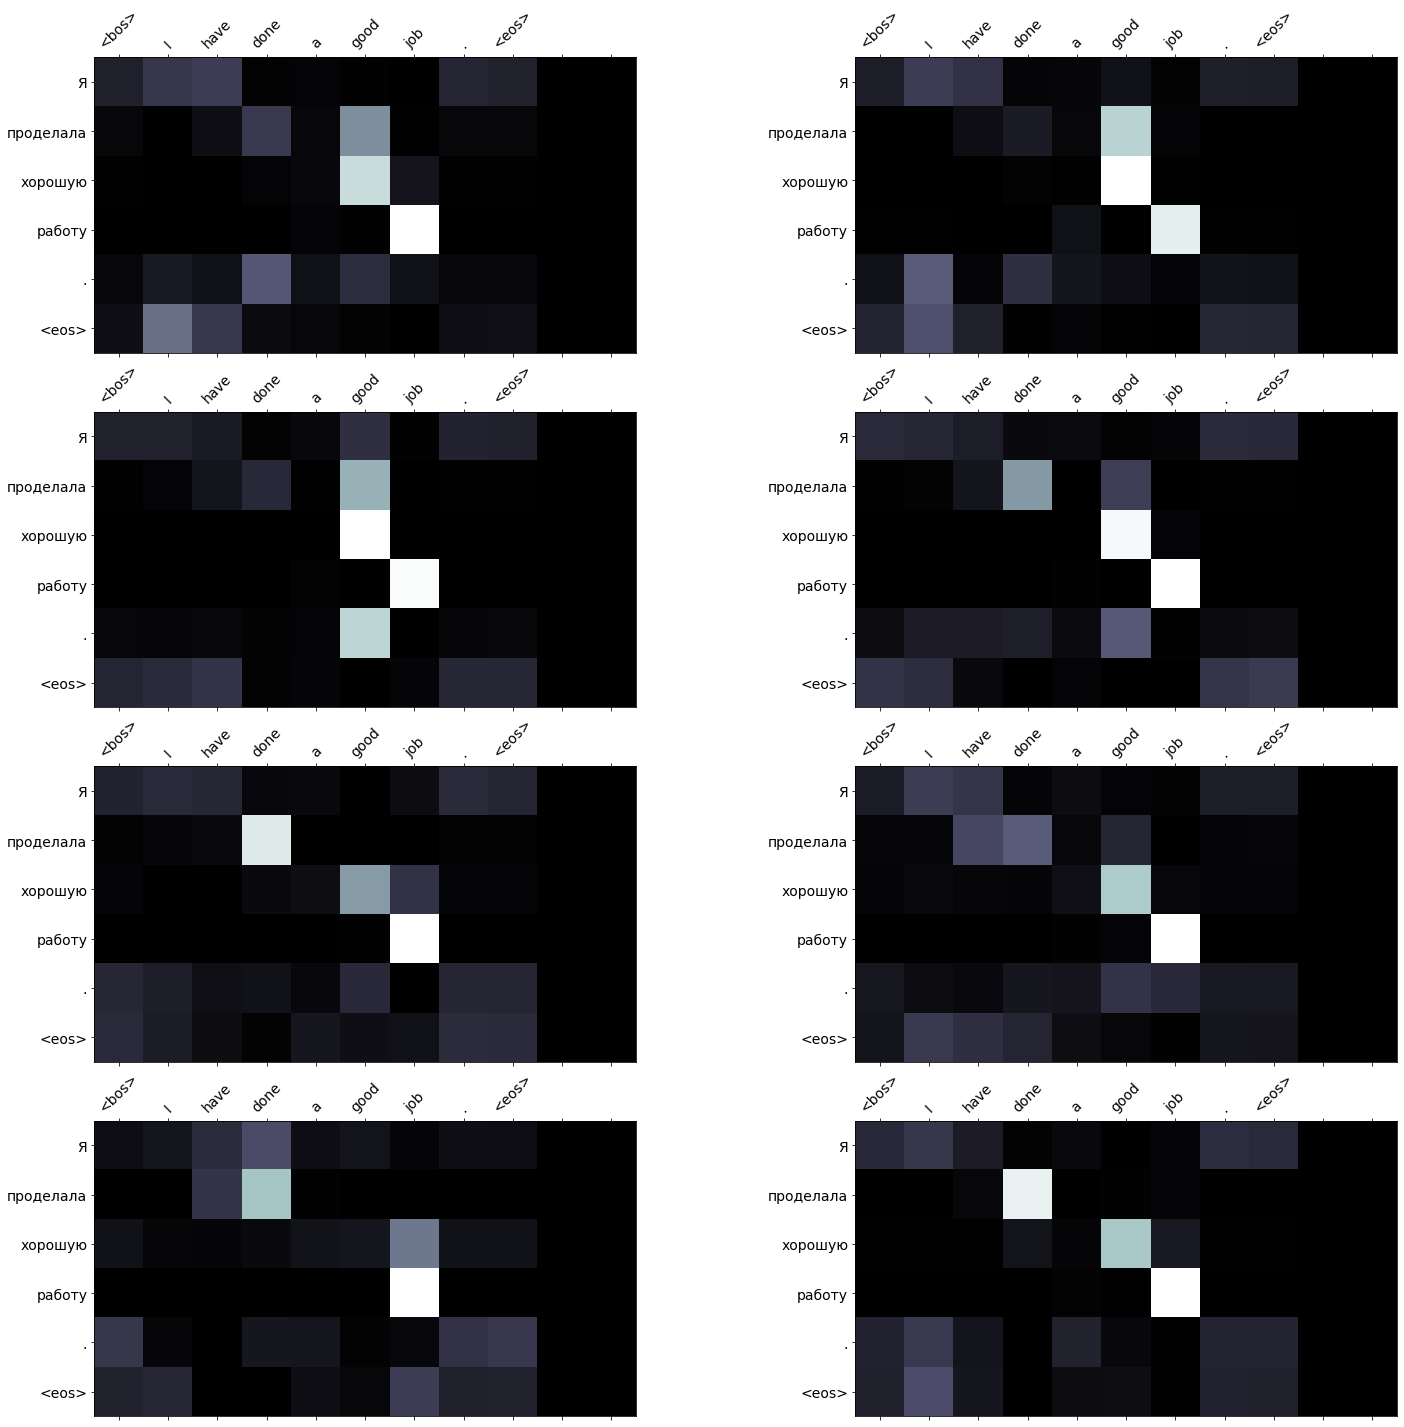


Оригинал перевода = ['Музыка', 'смолкла', '.']
То что перевела нейросеть = ['Музыка', 'смолкла', '.', '<eos>']


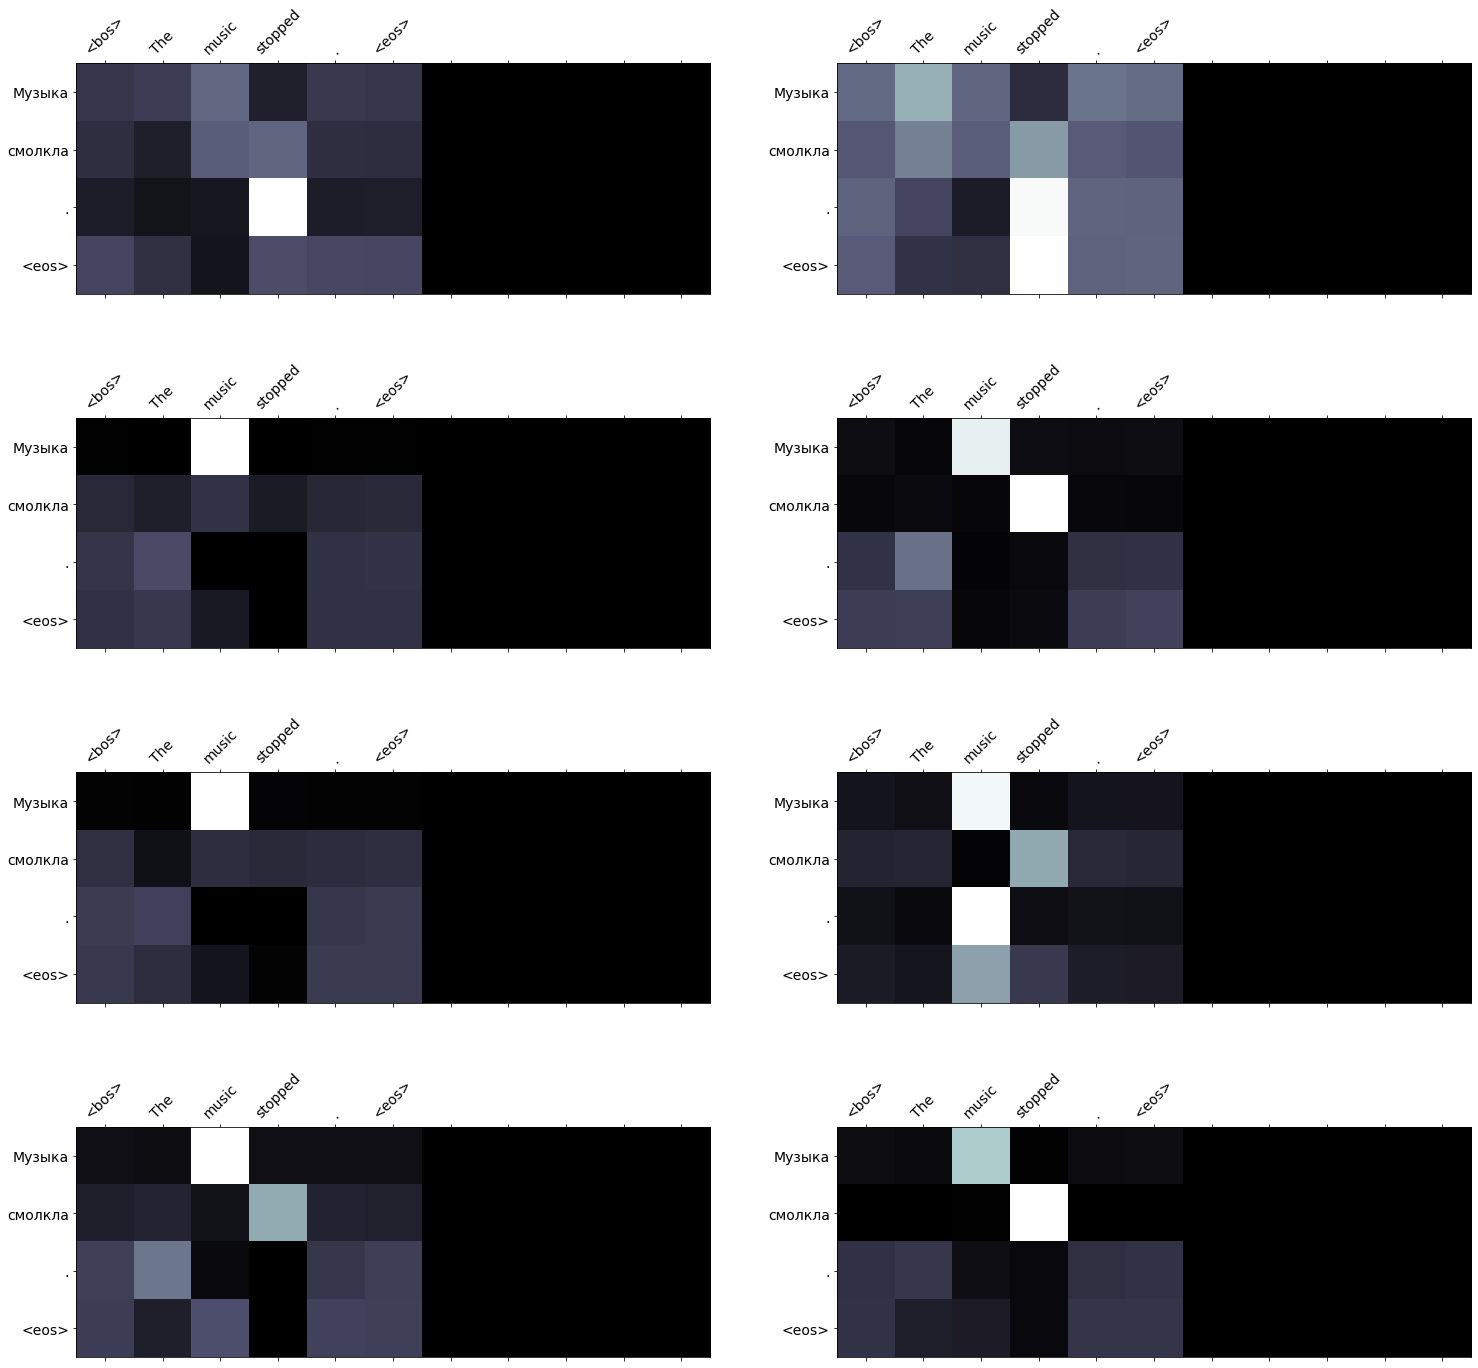


Оригинал перевода = ['Ты', 'видела', ',', 'что', 'я', 'сделал', '?']
То что перевела нейросеть = ['Ты', 'видел', ',', 'что', 'я', 'сделал', '?', '<eos>']


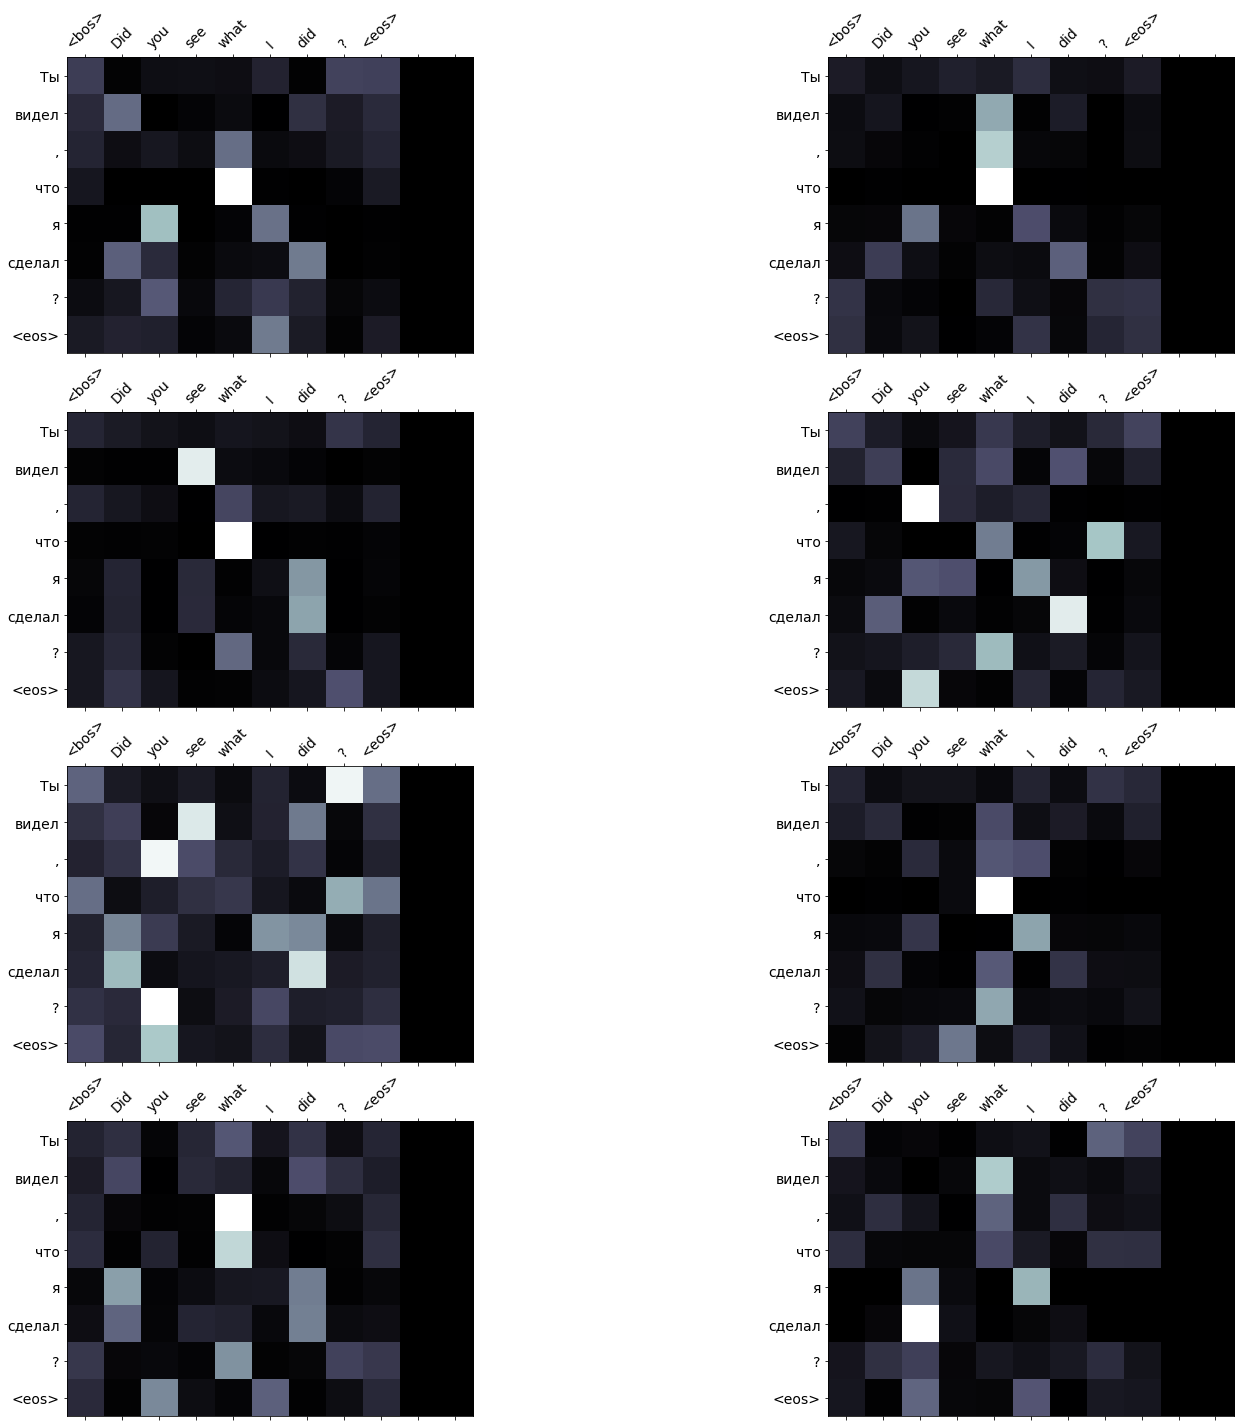


Оригинал перевода = ['Это', 'ключ', '.']
То что перевела нейросеть = ['Это', 'ключ', '.', '<eos>']


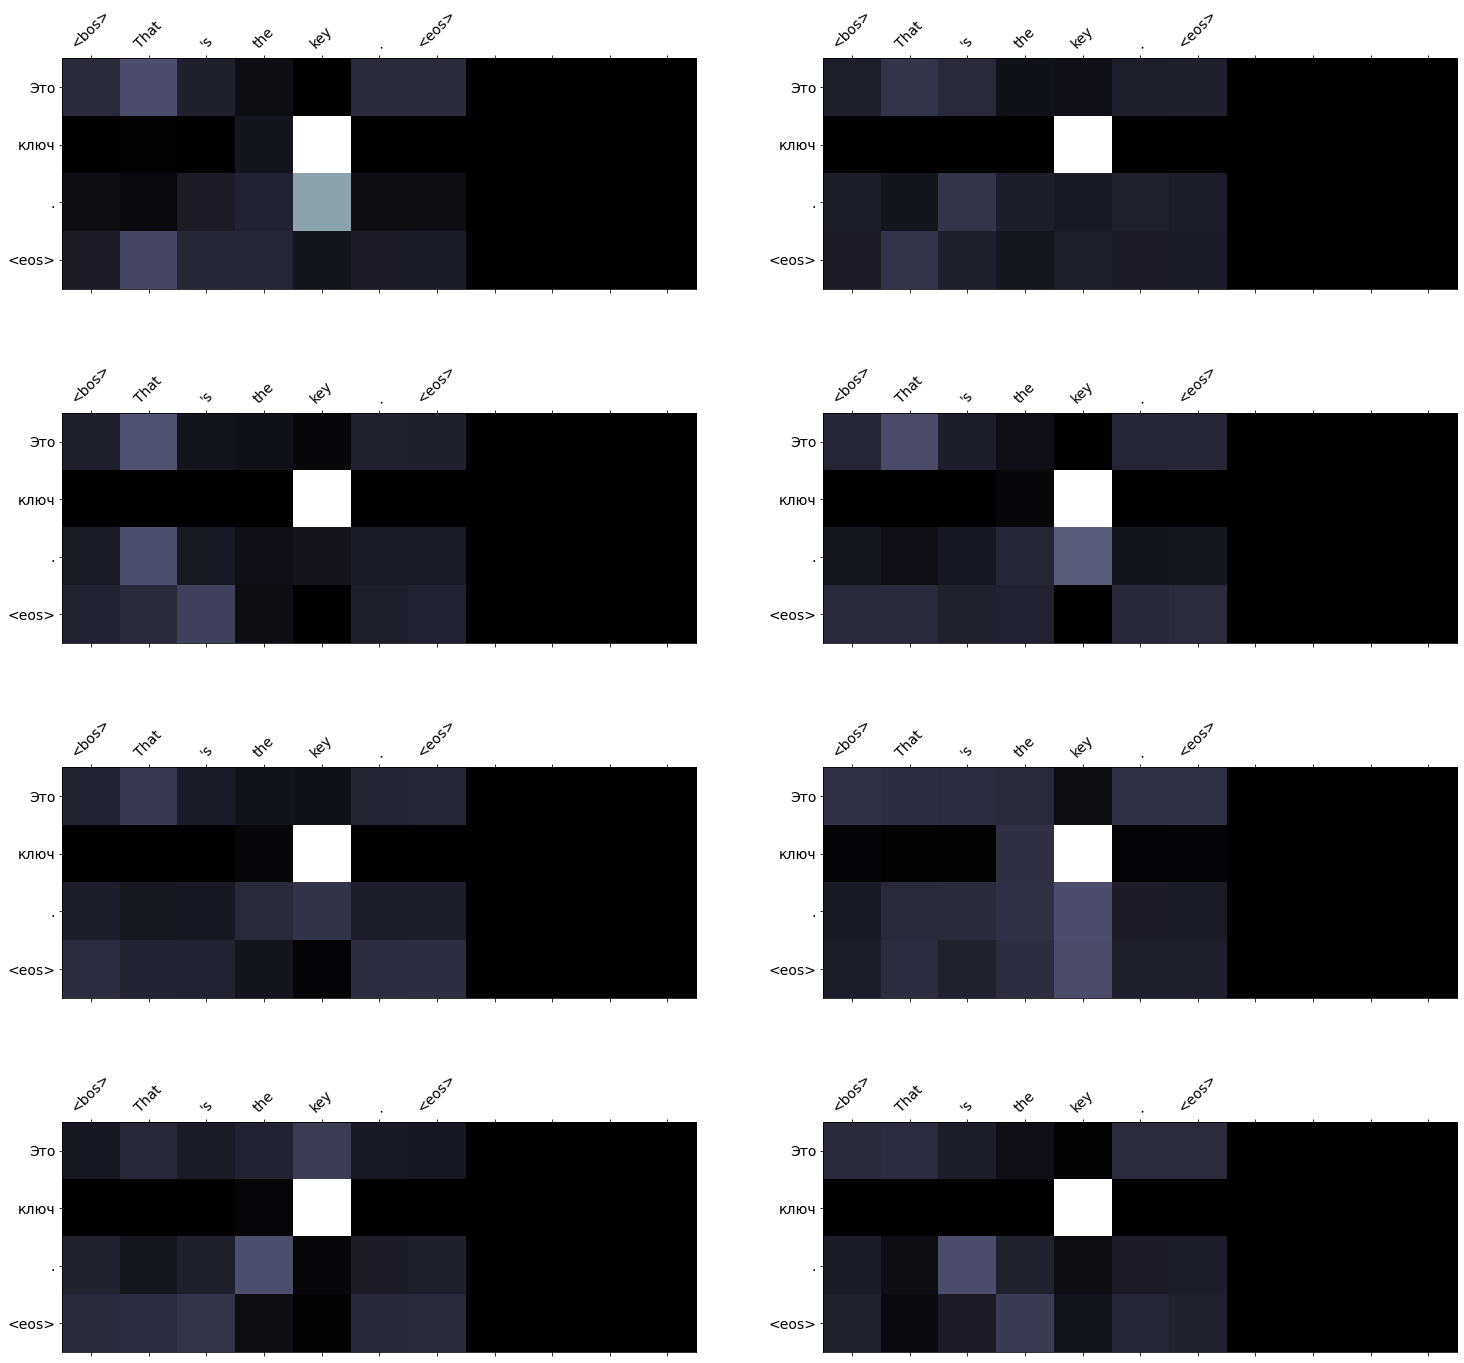


Оригинал перевода = ['Я', 'не', 'могу', 'ждать', 'так', 'долго', '.']
То что перевела нейросеть = ['Я', 'не', 'могу', 'ждать', 'так', 'долго', '.', '<eos>']


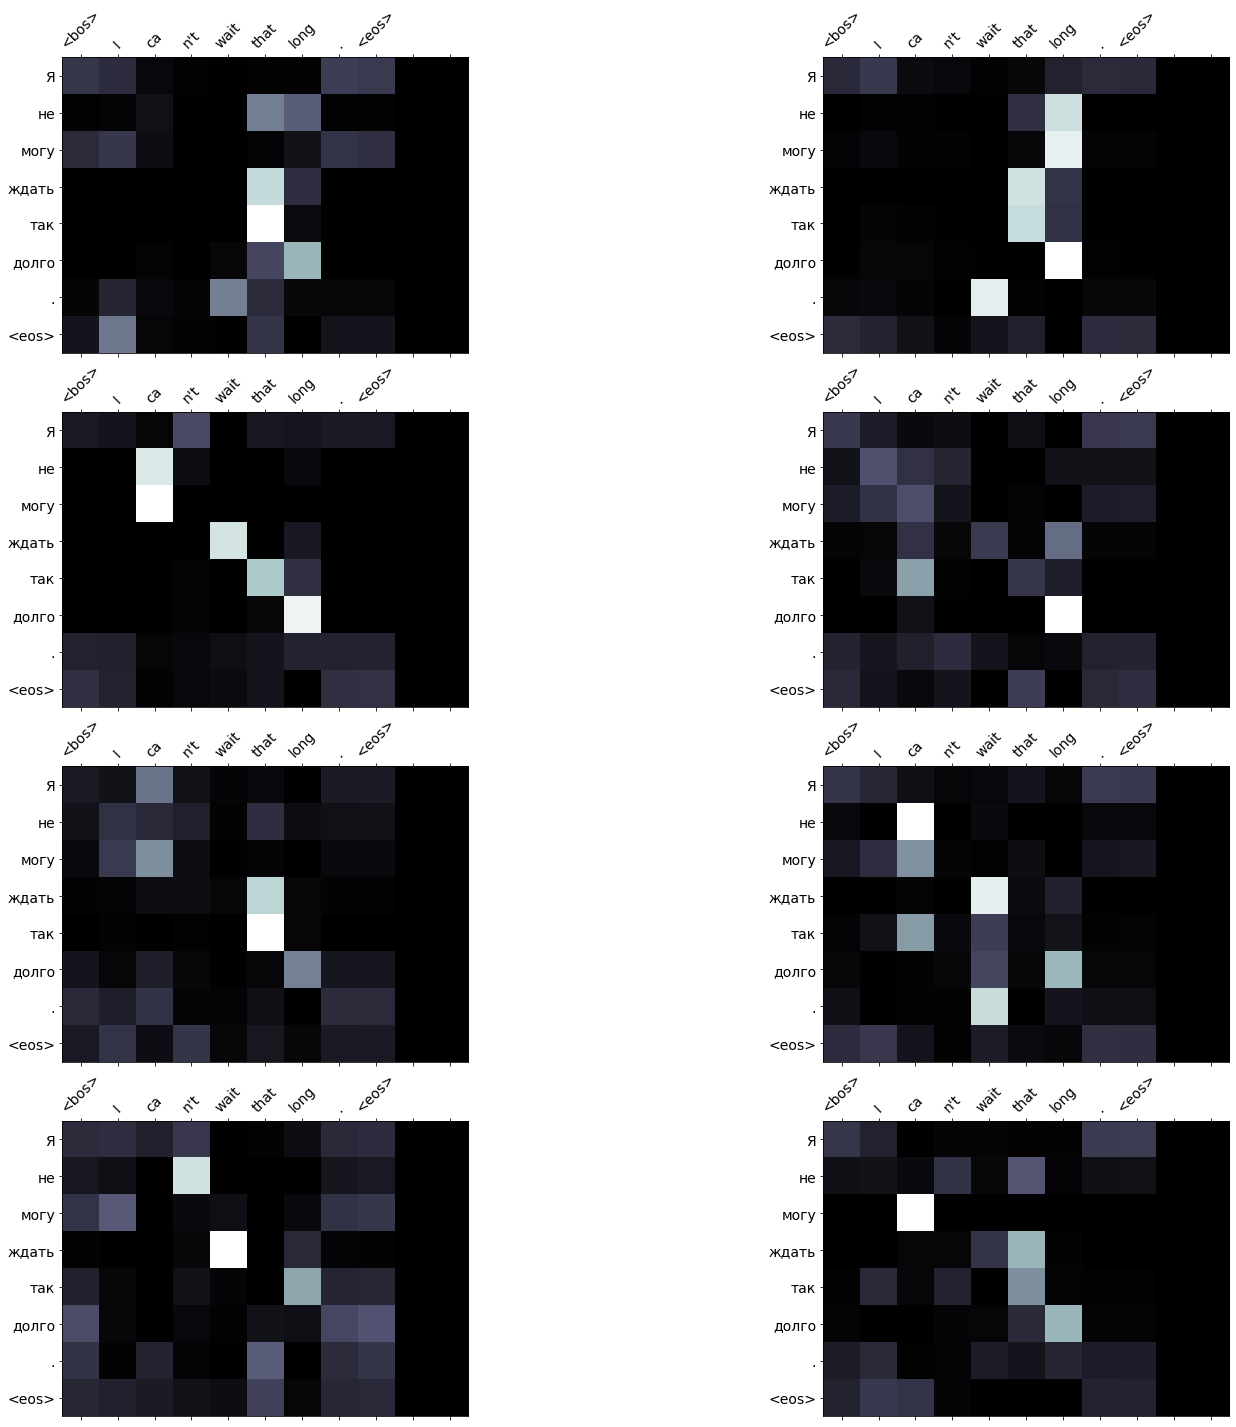


Оригинал перевода = ['Это', 'моя', 'жена', '.']
То что перевела нейросеть = ['Это', 'моя', 'жена', '.', '<eos>']


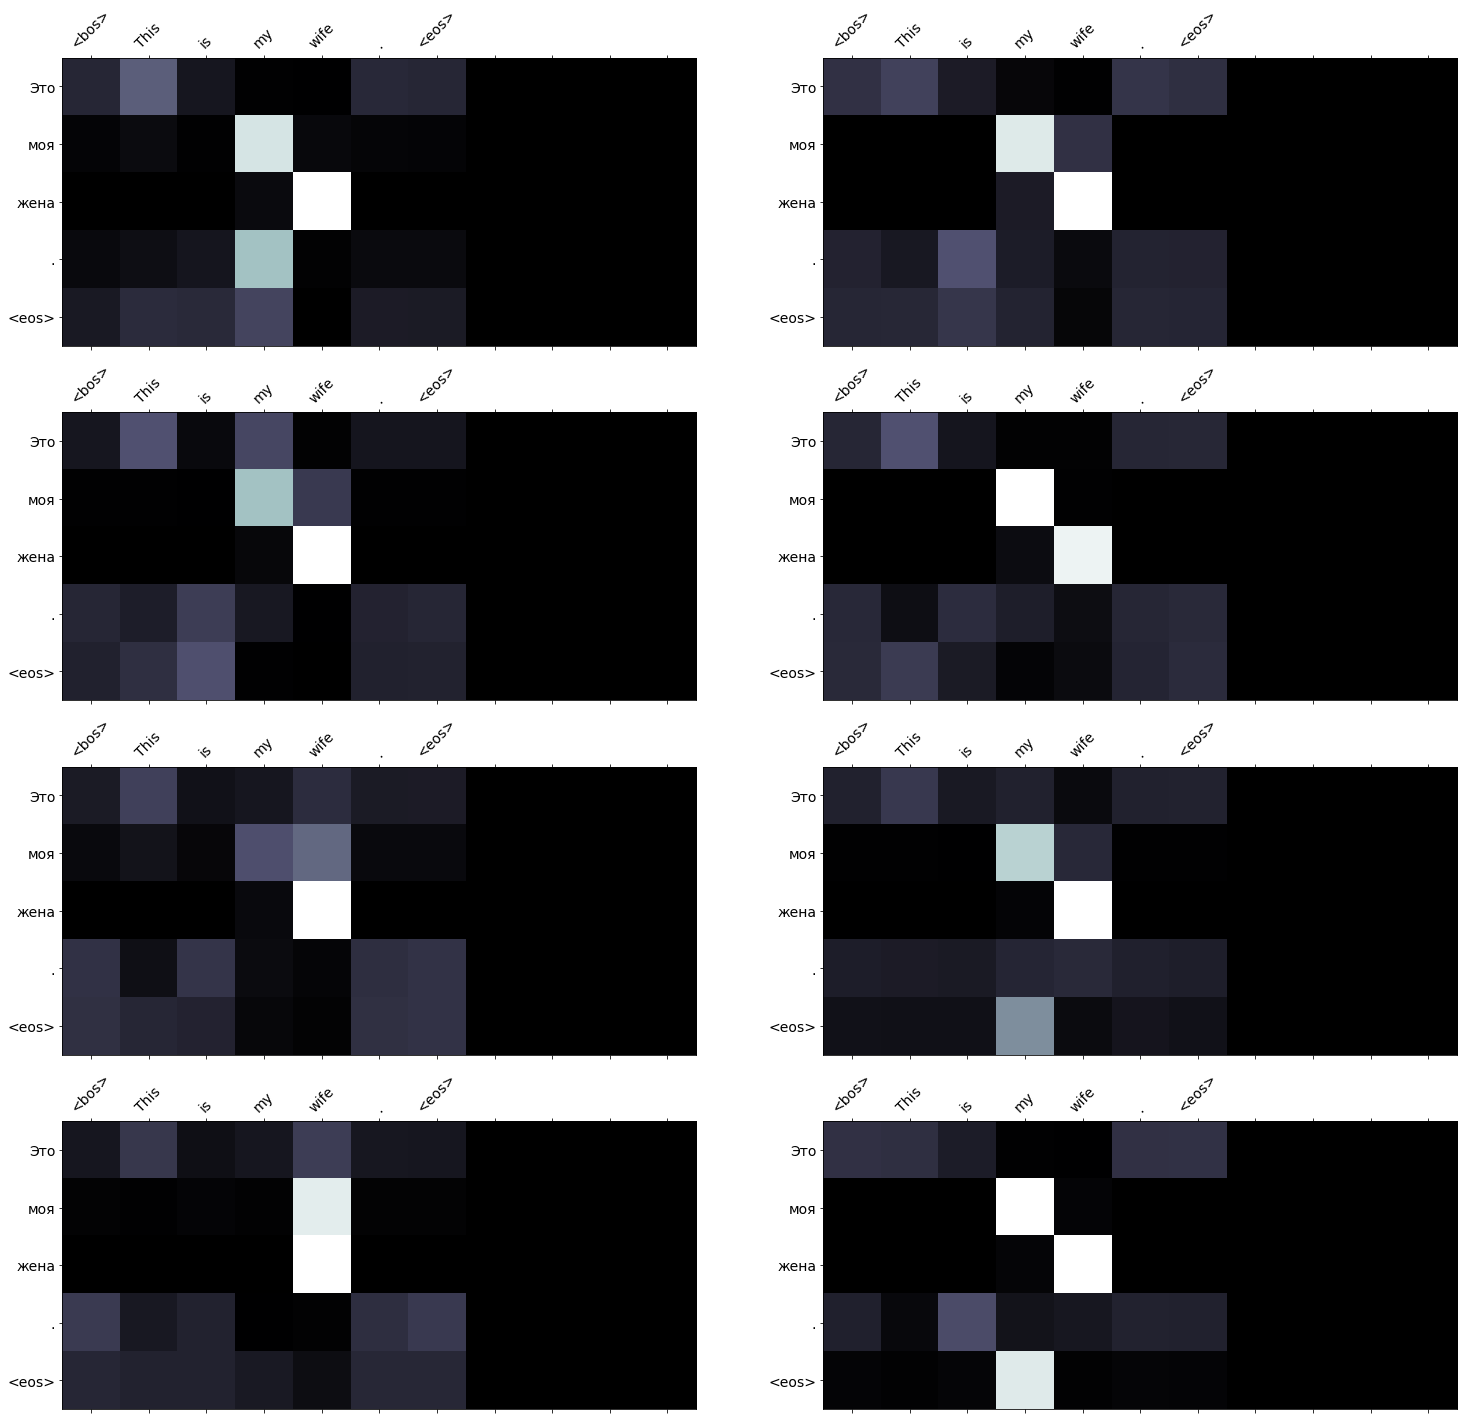

In [ ]:
for i in range(10):
  display_attention(i)

In [ ]:
trgs = []
pred_trgs = []
for i in range(10):
  trgs.append([vocab_transform['ru'].lookup_tokens(ru_test[i])])
  sentence = src_list[i].view(1, -1).to(device)
  pred, _ = translate_sentence(sentence, model, device, sentence.shape[-1])
  pred_trgs.append(pred[:-1])

In [ ]:
from torchtext.data.metrics import bleu_score
print(f'BLEU score = {bleu_score(pred_trgs, trgs)*100:.2f}')

BLEU score = 48.65
